REGRESSOR CNN

In [1]:
import os
import tensorflow as tf

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Configurazione manuale (più sicura)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("MEmory Growth attivata su GPU")
    except RuntimeError as e:
        print(e)

        
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_absolute_error
import gc

try:
    tf.config.experimental.enable_op_determinism()
    print("Op Determinism Abilitato!")
except AttributeError:
    print("Attenzione: La tua versione di TF è troppo vecchia per enable_op_determinism.")

def reset_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
SEEDS = [7,42,555]

I0000 00:00:1765789041.854006  231341 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765789041.885266  231341 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765789042.460531  231341 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


MEmory Growth attivata su GPU
2.21.0-dev20251210
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Op Determinism Abilitato!


W0000 00:00:1765789043.176434  231341 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


DATASET LOADING

In [2]:
def load_dataset():
    folder='dataset/images'
    data=[]
    for filename in sorted(os.listdir(folder)):   
        img_path=os.path.join(folder,filename)
        img=cv2.imread(img_path) #opencv save in bgr
        data.append({
            'image':img,
            'filename':filename
        })

    data_map = {item['filename']: item['image'] for item in data}
    label=pd.read_csv('dataset/raw/bbx_annotations.csv')
    #just to avoid warning
    coords = ['xmin', 'xmax', 'ymin', 'ymax']
    label[coords] = label[coords].astype(float)
    
    upper_mask = label['filename'].str.lower().str.contains('upper')
    label.loc[upper_mask, ['xmin', 'xmax', 'ymin', 'ymax']] /= 2
    
    for i,item in enumerate(data):
        if "upper" in item["filename"].lower():
            data[i]['image']=cv2.resize(
                data[i]['image'],
                (data[i]['image'].shape[1]//2,data[i]['image'].shape[0]//2)
                ,interpolation=cv2.INTER_AREA
            )
    return data, label

DATA MODELLING
train df will be: image--> w1, h1, w2,h2....w9,h9
where:w1 width of mean point of the bbox closer to x=0. if w9/h9 doesnt exist=-1 

In [ ]:
def dataset_modelling(data,annotation):
    dataset_df = pd.DataFrame(data) 

    annotation['bbox_width']  = (annotation['xmax'] + annotation['xmin'])/2
    annotation['bbox_height'] = (annotation['ymax'] + annotation['ymin'])/2
    
    grouped_w = annotation.groupby('filename')['bbox_width'].apply(list).reset_index()
    grouped_h = annotation.groupby('filename')['bbox_height'].apply(list).reset_index()

    bbox_count = grouped_w['bbox_width'].apply(len)
    print(max(bbox_count)) #9
    MAX_OBJECTS = 9
    merged = pd.merge(grouped_w, grouped_h, on='filename')
    target_vectors = []
    for i,row in merged.iterrows():
        width  = [w / 320 for w in row['bbox_width']]
        height = [h / 240 for h in row['bbox_height']]
        # width = row['bbox_width']
        # height = row['bbox_height']
        pairs=list(zip(width,height))

        pairs.sort(key=lambda x: x[0])
        flat_list = [val for pair in pairs for val in pair]

        target_len = MAX_OBJECTS * 2
        if len(flat_list) < target_len:
            flat_list.extend([0.0] * (target_len - len(flat_list)))
        elif len(flat_list) > target_len: #shouldnt happen
            flat_list = flat_list[:target_len]
        target_vectors.append(np.array(flat_list, dtype='float32'))

    merged['target']=target_vectors
    final_df = pd.merge(dataset_df, merged[['filename', 'target']], on='filename')
    final_df = final_df.drop('filename', axis=1)
    #print(final_df)

    train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

    x_train = np.array(train_df['image'].tolist()).astype('float32') / 255.0
    y_train = np.array(train_df['target'].tolist()).astype('float32')

    x_test = np.array(test_df['image'].tolist()).astype('float32') / 255.0
    y_test = np.array(test_df['target'].tolist()).astype('float32')

    return x_train,y_train,x_test,y_test

PARAMETER SEARCH

In [4]:
def create_hyperparam_combination():
    param_grid = {
    'batch_size': [16],
    'layer_number':[8,5],
    'kernel_dim': [3,7],
    'pool_dim': [3], 
    'lr': [0.0001,0.001,0.00001],
    'fc1' : [256,1024],
    'fc2': [256]     
}

    #every possible combination
    keys, values = zip(*param_grid.items())
    combinations = list(itertools.product(*values))
    combinations_dicts = [dict(zip(keys, v)) for v in combinations]
    return combinations_dicts

BUILDING MODEL

In [5]:
def build_model(layer_num,kernel_dim,pool_dim,fc1,fc2):
    model=models.Sequential()
    model.add(tf.keras.Input(shape=(240,320,3)))

    for i in range(layer_num):
        kernel_number=16*(2**i)
        model.add(layers.Conv2D(kernel_number,(kernel_dim,kernel_dim),activation='relu',padding='same'))
        model.add(layers.AveragePooling2D((pool_dim,pool_dim),strides=2,padding='same'))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(fc1,activation='relu'))
    model.add(layers.Dense(fc2,activation='relu'))
    model.add(layers.Dense(18,activation='sigmoid'))

    #model.summary()
    return model

In [6]:
def masked_mse(y_true,y_pred):
    mask = tf.cast(tf.math.not_equal(y_true, 0.0), tf.float32)
    squared_error = tf.square(y_true - y_pred)
    masked_error = squared_error * mask
    loss = tf.reduce_sum(masked_error) / (tf.reduce_sum(mask) + 1e-9)
    return loss

SAVE CSV

In [7]:
def save_csv(r2,param,seed,all_results):
    current_result = param.copy()  
    current_result['mae_Score']=r2

    all_results.append(current_result)

    pd.DataFrame(all_results).to_csv(f'regression/csv/search/firstsearch_{seed}.csv', index=False)




MAIN

In [ ]:
data,annotation=load_dataset()
x_train,y_train, x_test, y_test=dataset_modelling(data,annotation)
combination=create_hyperparam_combination()

final_results = []
for seed in SEEDS:
    print(f"\n ================== INIZIO CICLO CON SEED: {seed} ================== ")
    all_results = []
    bestr2=100000
    current_seed_best_params = {}
    for i,param in enumerate(combination):
        tf.keras.backend.clear_session()
        gc.collect()
        reset_seeds(seed)
        model=build_model( param['layer_number'],param['kernel_dim'],param['pool_dim'],param['fc1'],param['fc2'])
        opt=tf.keras.optimizers.Adam(learning_rate=param['lr'])
        model.compile(optimizer=opt,
                        loss=masked_mse,
                        metrics=['mae'])
        early_stop=EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
            )
        
        reset_seeds(seed)
        history=model.fit(
                x_train,y_train,
                epochs=120,
                batch_size=param['batch_size'], 
                validation_split=0.2, 
                callbacks=[early_stop]
                )
        y_pred=model.predict(x_test)
        mae = mean_absolute_error(y_test, y_pred)
        print("MAE:", mae)
        if mae<bestr2:
            bestr2=mae
            current_seed_best_params = param.copy()
        save_csv(mae,param,seed,all_results)
        print("\n--- ESEMPIO PREDIZIONE ---")
        idx = 80
        real_vals = y_test[idx]
        pred_vals = model.predict(x_test[idx:idx+1])[0]

        print(f"Reale (primi 4 valori): {real_vals[:4]}")
        print(f"Predetto (primi 4 valori): {pred_vals[:4]}")


    current_seed_best_params['seed'] = seed
    current_seed_best_params['best_mae_score'] = bestr2
    print(current_seed_best_params)

    final_results.append(current_seed_best_params)

df_best_results = pd.DataFrame(final_results)
df_best_results.to_csv('regression/csv/best_model/firsttry_customloss.csv', index=False)




9

 ================== INIZIO CICLO CON SEED: 7 ================== 


W0000 00:00:1765789045.126680  231341 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1765789045.198315  231341 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9264 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


Epoch 1/120


I0000 00:00:1765789047.097433  231509 cuda_dnn.cc:461] Loaded cuDNN version 91600


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0580 - mae: 0.4108 - val_loss: 0.0485 - val_mae: 0.4066
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0445 - mae: 0.3991 - val_loss: 0.0410 - val_mae: 0.4024
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0412 - mae: 0.3981 - val_loss: 0.0408 - val_mae: 0.3986
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0405 - mae: 0.3989 - val_loss: 0.0404 - val_mae: 0.3986
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0401 - mae: 0.3983 - val_loss: 0.0401 - val_mae: 0.3970
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0398 - mae: 0.3977 - val_loss: 0.0398 - val_mae: 0.3954
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0394 - mae: 0.3978 - val_loss: 0.0393 - val_mae: 0.3971
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0391 - mae: 0.3988 - val_loss: 0.0390 - val_mae: 0.3994
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0389 -

E0000 00:00:1765789253.881908  231341 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 0.4241204559803009

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.10832928 0.3381887  0.29631105 0.27217126]
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0571 - mae: 0.3952 - val_loss: 0.0487 - val_mae: 0.3929
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0438 - mae: 0.3886 - val_loss: 0.0410 - val_mae: 0.3930
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0413 - mae: 0.3903 - val_loss: 0.0406 - val_mae: 0.3923
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0404 - mae: 0.3928 - val_loss: 0.0402 - val_mae: 0.3932
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0400 - mae: 0.3937 - val_loss: 0.0398 - val_mae: 0.3933
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0397 - mae: 0.3943 - val_loss: 0.0395 - val_mae: 0.3934
Epoch 7/120
88/88 ━

E0000 00:00:1765789436.357494  231341 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.43573591113090515

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.04638624 0.25315925 0.15381873 0.19603215]
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0533 - mae: 0.4063 - val_loss: 0.0415 - val_mae: 0.4103
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0422 - mae: 0.4009 - val_loss: 0.0405 - val_mae: 0.4026
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0418 - mae: 0.4026 - val_loss: 0.0400 - val_mae: 0.4050
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0410 - mae: 0.4049 - val_loss: 0.0396 - val_mae: 0.4050
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0404 - mae: 0.4062 - val_loss: 0.0400 - val_mae: 0.3996
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0398 - mae: 0.4056 - val_loss: 0.0389 - val_mae: 0.4027
Epoch 7/120
88/88 

E0000 00:00:1765789577.895423  231341 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAE: 0.45205941796302795

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.10068756 0.3358362  0.2326952  0.35178432]
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0583 - mae: 0.3970 - val_loss: 0.0455 - val_mae: 0.3897
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0432 - mae: 0.3916 - val_loss: 0.0403 - val_mae: 0.3985
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0420 - mae: 0.3960 - val_loss: 0.0407 - val_mae: 0.3947
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0408 - mae: 0.3981 - val_loss: 0.0398 - val_mae: 0.3953
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0398 - mae: 0.4010 - val_loss: 0.0395 - val_mae: 0.3977
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0393 - mae: 0.4035 - val_loss: 0.0385 - val_mae: 0.3984
Epoch 7/120
88/88 

E0000 00:00:1765789730.303405  231341 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 0.43537622690200806

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.10032246 0.25387642 0.2609847  0.312413  ]
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0714 - mae: 0.4218 - val_loss: 0.0589 - val_mae: 0.4103
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0568 - mae: 0.4062 - val_loss: 0.0558 - val_mae: 0.4137
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0550 - mae: 0.4076 - val_loss: 0.0544 - val_mae: 0.4137
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0532 - mae: 0.4056 - val_loss: 0.0515 - val_mae: 0.4097
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0484 - mae: 0.3981 - val_loss: 0.0444 - val_mae: 0.3952
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0436 - mae: 0.3919 - val_loss: 0.0421 - val_mae: 0.3927
Epoch 7/120
88/88 


--- Analisi Centri Immagine 42 ---
Reale 1: (46, 90) px
Reale 2: (155, 53) px
Reale 3: (246, 78) px
Reale 4: (246, 151) px
Predetto 1: (28, 93) px
Predetto 2: (61, 92) px
Predetto 3: (147, 80) px
Predetto 4: (231, 103) px
Predetto 5: (265, 99) px
Predetto 6: (287, 76) px
Predetto 7: (286, 119) px
Predetto 8: (286, 76) px
Predetto 9: (234, 32) px


E0000 00:00:1765713039.560314 3916396 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


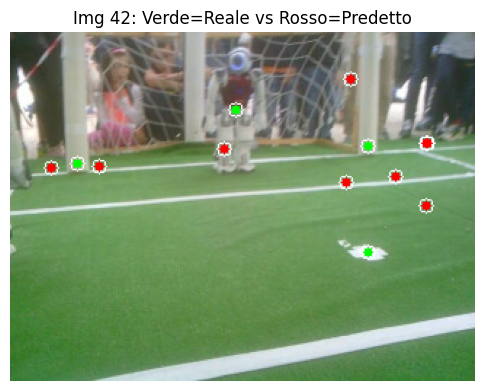


--- Analisi Centri Immagine 18 ---
Reale 1: (45, 48) px
Predetto 1: (50, 60) px
Predetto 2: (100, 43) px
Predetto 3: (134, 47) px
Predetto 4: (161, 62) px
Predetto 5: (185, 43) px
Predetto 6: (203, 43) px
Predetto 7: (231, 41) px
Predetto 8: (242, 46) px
Predetto 9: (253, 42) px


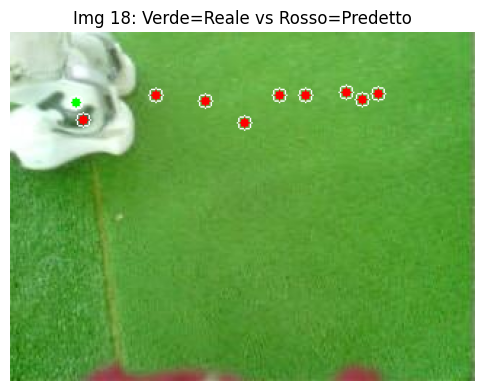

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_only_centers(model, x_test, y_test, index=0):
    """
    Visualizza solo i CENTRI (x, y) degli oggetti.
    Verde = Centro Reale (Target)
    Rosso = Centro Predetto dal Modello
    """
    # 1. Recupera immagine e target
    img_norm = x_test[index].copy()
    real_targets = y_test[index]
    
    # 2. Fai la predizione
    # Aggiungiamo dimensione batch: (1, 128, 128, 3)
    pred_targets = model.predict(x_test[index:index+1], verbose=0)[0]
    
    # 3. Preparazione Immagine (Denormalizza 0-255 per display)
    if img_norm.max() <= 1.0:
        img_display = (img_norm * 255).astype(np.uint8)
    else:
        img_display = img_norm.astype(np.uint8)
        
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
    
    # Dimensioni immagine per convertire da 0-1 a pixel
    IMG_H, IMG_W = img_display.shape[:2]
    
    print(f"\n--- Analisi Centri Immagine {index} ---")

    # Funzione per disegnare i punti
    def draw_points(targets, color, label):
        # Itera a passi di 2 (x, y)
        for i in range(0, len(targets), 2):
            if i+1 >= len(targets): break
            
            xc = targets[i]
            yc = targets[i+1]
            
            # Filtro padding: se il punto è (0,0) o molto vicino, lo ignoriamo
            if xc < 0.01 and yc < 0.01: continue
            
            # Converti in pixel
            xc_px = int(xc * IMG_W)
            yc_px = int(yc * IMG_H)
            
            # Disegna il cerchio (Raggio 3 pixel, Pieno)
            cv2.circle(img_display, (xc_px, yc_px), 3, color, -1)
            
            # Opzionale: Disegna un cerchio vuoto attorno per vederlo meglio
            cv2.circle(img_display, (xc_px, yc_px), 5, (255, 255, 255), 1)
            
            print(f"{label} {i//2+1}: ({xc_px}, {yc_px}) px")

    # DISEGNA I PUNTI
    # Verde (0, 255, 0) per i REALI
    draw_points(real_targets, (0, 255, 0), "Reale")
    
    # Rosso (255, 0, 0) per i PREDETTI
    draw_points(pred_targets, (255, 0, 0), "Predetto")

    # Mostra l'immagine
    plt.figure(figsize=(6,6))
    plt.imshow(img_display)
    plt.title(f"Img {index}: Verde=Reale vs Rosso=Predetto")
    plt.axis('off')
    plt.show()

# --- ESEGUI IL TEST ---
# Cambia l'indice per vedere diverse foto
visualize_only_centers(model, x_test, y_test, index=42)
visualize_only_centers(model, x_test, y_test, index=18)